#### spateGAN-ERA5 spatiotemporal precipitation downscaling example
https://doi.org/10.48550/arXiv.2411.16098

In [1]:
%load_ext autoreload
%autoreload 2
import torch
from model import Generator  
from train import train, validation
from data import readFile, make_temporal_batches, block_average_pooling
import xarray as xr
import numpy as np
from einops import rearrange

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#### load dataset and train the model


In [3]:
x_train_pr = readFile('data/gcm/pr_*.nc', 'pr', 1, 21, 31)
x_train_wind = readFile('data/gcm/sfcWind_*.nc', 'sfcWind', 1, 21, 31)
x_train_hurs = readFile('data/gcm/hurs_*.nc', 'hurs', 1, 21, 31)
x_train_huss = readFile('data/gcm/huss_*.nc', 'huss', 1, 21, 31)
x_train_rlds = readFile('data/gcm/rlds_*.nc', 'rlds', 1, 21, 31)
x_train_rsds = readFile('data/gcm/rsds_*.nc', 'rsds', 1, 21, 31)
x_train_tas = readFile('data/gcm/tas_*.nc', 'tas', 1, 21, 31)
x_train_tasmax = readFile('data/gcm/tasmax_*.nc', 'tasmax', 1, 21, 31)
x_train_tasmin = readFile('data/gcm/tasmin_*.nc', 'tasmin', 1, 21, 31)

#x_train = np.concatenate([x_train_pr, x_train_wind, x_train_hurs, x_train_huss], axis=1)
x_train = np.concatenate([x_train_pr, x_train_wind, x_train_hurs, x_train_huss, 
                          x_train_rlds, x_train_rsds, x_train_tas, x_train_tasmax, x_train_tasmin], axis=1)
mean_vals = np.nanmean(x_train, axis=(0, 2, 3))
for c in range(x_train.shape[1]):
    x_train[:, c, :, :] = np.where(np.isnan(x_train[:, c, :, :]), 0.0, x_train[:, c, :, :])
print(x_train.shape)

final shape (3650, 1, 21, 31)
final shape (3650, 1, 21, 31)
final shape (3650, 1, 21, 31)
final shape (3650, 1, 21, 31)
final shape (3650, 1, 21, 31)
final shape (3650, 1, 21, 31)
final shape (3650, 1, 21, 31)
final shape (3650, 1, 21, 31)
final shape (3650, 1, 21, 31)
(3650, 9, 21, 31)


In [ ]:
data_aorc = readFile('data/aorc/APCP_surface_*.nc', 'APCP_surface', 24, 21, 31)
data_aorc = data_aorc.reshape(-1, 1, 24, 21, 31).sum(axis=2)
mean_val = np.nanmean(data_aorc)
data_aorc = np.where(np.isnan(data_aorc), 0.0, data_aorc)
print(data_aorc.shape)

final shape (3650, 24, 21, 31)
(3650, 1, 21, 31)


In [9]:
input, target = make_temporal_batches(x_train, data_aorc)
print(input.shape)
print(target.shape)

(1216, 9, 3, 21, 31)
(1216, 1, 3, 21, 31)


In [ ]:
train(input, target)

#### load model and weights and test the model


In [6]:
model = Generator().to(device)
model.load_state_dict(torch.load('model_weights/models.pth'))
model.eval()
x = x_train[600:605]
y = data_aorc[600:605]
input, target = make_temporal_batches(x, y)
input = torch.tensor(input, device=device).float()            
target = torch.tensor(target, device=device).float()
print(input.shape)
print(target.shape)

torch.Size([1, 9, 5, 21, 31])
torch.Size([1, 1, 5, 21, 31])


fss: 0.82896


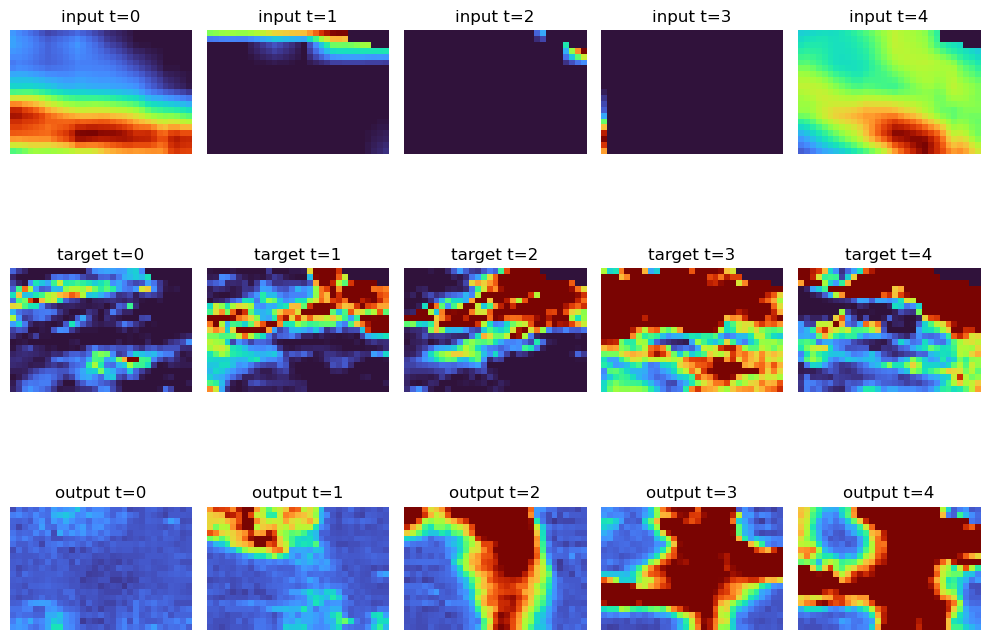

In [7]:
validation(model, input, target)